In [1]:
import numpy as np
import pandas as pd
from sksurv.util import Surv
from tqdm import tqdm
from icare.survival import IcareSurv, BaggedIcareSurv
from sklearn.model_selection import cross_val_score, ShuffleSplit
from joblib import Parallel, delayed
from icare.metrics import harrell_cindex
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/home/louis/Documents/work/uncool_package/dev/df_train.csv', index_col='PatientID')
df.shape

(486, 2433)

In [3]:
features = list(set(df.columns.tolist()) - set(['Relapse', 'RFS', 'Task 1', 'Task 2', 'CenterID']))
features = [x for x in features if 'lesions_merged' not in x and 'lymphnodes_merged' not in x]
extra_features = ['Gender',
                  'Age',
                  'Weight',
                  'Tobacco',
                  'Alcohol',
                  'Performance status',
                  'HPV status (0=-, 1=+)',
                  'Surgery',
                  'Chemotherapy', 'nb_lesions', 'nb_lymphnodes', 'whole_body_scan']

features_groups = np.unique([x.split('_shape_')[0].split('_PT_')[0].split('_CT_')[0] for x in features])
features_groups = list(set(features_groups) - set(extra_features))
features_groups = [x + '_' for x in features_groups]
features_groups.append('extra_features')
len(features_groups), features_groups

(14,
 ['everything_mergedBBox_',
  'everything_mergedshell4mm_',
  'everything_mergeddilat8mm_',
  'everything_merged2.5_',
  'everything_mergedshell2mm_',
  'everything_mergedshell8mm_',
  'everything_mergeddilat2mm_',
  'everything_merged4_',
  'everything_mergeddilat1mm_',
  'everything_merged40%_',
  'everything_merged_',
  'everything_mergeddilat16mm_',
  'everything_mergeddilat4mm_',
  'extra_features'])

In [4]:
y = Surv.from_arrays(event=df['Relapse'].values,
                     time=df['RFS'].values)
X = df[features]
mask_keep = (X.isna().sum(axis=1) < 1000).values
X, y = X.iloc[mask_keep], y[mask_keep]

In [5]:
features_groups_id = []
for f in X.columns:
    if f in extra_features:
        features_groups_id.append(features_groups.index('extra_features'))
    else:
        group = f.split('_shape_')[0].split('_PT_')[0].split('_CT_')[0] + '_'
        features_groups_id.append(features_groups.index(group))

# Hyperparameters sets search

In [6]:
def worker_cv_paral(model, X, y, feature_group, train_index, test_index):
    try:
        model.fit(X.iloc[train_index], y[train_index], feature_groups=feature_group)
        pred = model.predict(X.iloc[test_index])
        return harrell_cindex(y[test_index], pred)
    except:
        return np.nan

def cv_paral(model, X, y, feature_group, n_folds):
    cv = ShuffleSplit(n_splits=n_folds, test_size=.5)
    scores = Parallel(n_jobs=-1)(delayed(worker_cv_paral)(model, X, y, feature_group, train_index, test_index)
                                 for train_index, test_index in cv.split(X))

    return np.nanmean(scores)

In [7]:
def get_random_params():
     return {
    'max_features': np.random.uniform(1/len(features), 500/len(features)),
    'rho': np.round_(np.random.uniform(0.2,0.9), 2),
    'cmin': np.round_(np.random.uniform(0.5,0.6), 2),
    'mandatory_features': extra_features,
    'features_groups_to_use': np.random.choice(features_groups,
                                               np.random.randint(len(features_groups)),
                                               replace=False).tolist()
}

In [8]:
from tqdm import tqdm
best_score = None
for _ in tqdm(range(10)):
    params = get_random_params()
    score = cv_paral(IcareSurv(**params), X, y, features_groups_id, n_folds=30)
    if best_score is None or best_score < score:
        best_score = score
        print('New best:')
        print(best_score)
        print(params)
        print()

 10%|█         | 1/10 [00:02<00:22,  2.50s/it]

New best:
0.5839569548707105
{'max_features': 0.1898758212008903, 'rho': 0.23, 'cmin': 0.53, 'mandatory_features': ['Gender', 'Age', 'Weight', 'Tobacco', 'Alcohol', 'Performance status', 'HPV status (0=-, 1=+)', 'Surgery', 'Chemotherapy', 'nb_lesions', 'nb_lymphnodes', 'whole_body_scan'], 'features_groups_to_use': ['everything_mergeddilat4mm_', 'extra_features', 'everything_mergedshell8mm_', 'everything_merged40%_', 'everything_mergeddilat8mm_', 'everything_mergeddilat1mm_']}



 30%|███       | 3/10 [00:05<00:11,  1.66s/it]

New best:
0.6317225389277467
{'max_features': 0.09664840408644747, 'rho': 0.63, 'cmin': 0.51, 'mandatory_features': ['Gender', 'Age', 'Weight', 'Tobacco', 'Alcohol', 'Performance status', 'HPV status (0=-, 1=+)', 'Surgery', 'Chemotherapy', 'nb_lesions', 'nb_lymphnodes', 'whole_body_scan'], 'features_groups_to_use': ['everything_mergeddilat2mm_', 'everything_mergeddilat1mm_', 'everything_mergeddilat8mm_', 'everything_merged4_', 'everything_merged2.5_', 'everything_mergeddilat16mm_', 'everything_mergeddilat4mm_', 'everything_mergedBBox_', 'everything_mergedshell4mm_', 'extra_features']}



100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


In [9]:
all_params_sets, all_scores = [], []
for _ in tqdm(range(1000)):
    params = get_random_params()
    model = BaggedIcareSurv(n_estimators=50,
                            parameters_sets=[params],
                            aggregation_method='median',
                            n_jobs=1)
    score = cv_paral(model, X, y, features_groups_id, n_folds=32)
    all_params_sets.append(params)
    all_scores.append(score)
sort_idx = np.argsort(all_scores)[::-1]
all_params_sets = np.array(all_params_sets)[sort_idx]
all_scores = np.array(all_scores)[sort_idx]

100%|██████████| 1000/1000 [7:34:02<00:00, 27.24s/it] 


In [10]:
all_scores[:5]

array([0.65844807, 0.65651886, 0.6558586 , 0.65490307, 0.65469963])

100%|██████████| 19/19 [09:27<00:00, 29.89s/it]

best_nb_sets 13


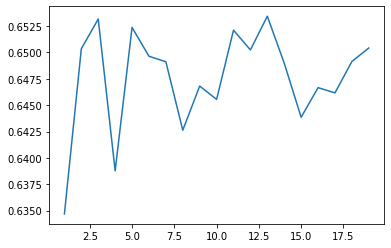

best hyperparameters_sets:
{'max_features': 0.05800627188810433, 'rho': 0.68, 'cmin': 0.54, 'mandatory_features': ['Gender', 'Age', 'Weight', 'Tobacco', 'Alcohol', 'Performance status', 'HPV status (0=-, 1=+)', 'Surgery', 'Chemotherapy', 'nb_lesions', 'nb_lymphnodes', 'whole_body_scan'], 'features_groups_to_use': ['everything_merged_', 'everything_mergedshell2mm_', 'everything_mergeddilat8mm_', 'everything_merged2.5_', 'everything_merged40%_', 'everything_mergeddilat2mm_', 'everything_mergedshell8mm_', 'everything_mergeddilat4mm_', 'everything_merged4_', 'everything_mergedshell4mm_', 'extra_features']}
{'max_features': 0.07159390804142017, 'rho': 0.86, 'cmin': 0.52, 'mandatory_features': ['Gender', 'Age', 'Weight', 'Tobacco', 'Alcohol', 'Performance status', 'HPV status (0=-, 1=+)', 'Surgery', 'Chemotherapy', 'nb_lesions', 'nb_lymphnodes', 'whole_body_scan'], 'features_groups_to_use': ['everything_merged4_', 'everything_mergedBBox_', 'everything_merged_', 'extra_features', 'everything_

In [11]:
all_score, all_nb_sets = [], []
for nb_sets in tqdm(range(1, 20)):
    sets = all_params_sets[:nb_sets]
    model = BaggedIcareSurv(n_estimators=50,
                            parameters_sets=sets,
                            aggregation_method='median',
                            n_jobs=1)
    score = cv_paral(model, X, y, features_groups_id, n_folds=32)
    all_nb_sets.append(nb_sets)
    all_score.append(score)
best_nb_sets = all_nb_sets[np.argmax(all_score)]
print("best_nb_sets", best_nb_sets)
plt.plot(all_nb_sets, all_score)
plt.show()
hyperparameters_sets = all_params_sets[:best_nb_sets]
print('best hyperparameters_sets:')
for x in hyperparameters_sets:
    print(x)

In [12]:
model = BaggedIcareSurv(n_estimators=100,
                        parameters_sets=hyperparameters_sets,
                        aggregation_method='median',
                        n_jobs=1)
score = cv_paral(model, X, y, features_groups_id, n_folds=128)
score

0.6439526293937456